# Sum of sinusoids benchmark for e-prop

## Goal: Shape random noise/spikes into target sum of sinusoids function

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# from torchvision.datasets import MNIST
# from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import snntorch as snn 
from snntorch import spikegen
# from snntorch.spikevision import spikedata
import snntorch.spikeplot as splt

import sys
sys.path.insert(1, '/home/james/code/hw-aware-eprop')

## Set useful parameters

In [47]:
params= {
    'dtype'     : torch.float32,
    'n_batch'     : 1,             # batch size of the testing set
    'n_out'       : 1,             # number of output neurons (number of target curves)
    'n_in'        : 100 ,          # number of input units
    'n_rec'       : 100,           # number of recurrent units

    'f0'          : 50 ,           # input firing rate
    'reg_rate'    : 10 ,           # target rate for regularization

    'n_iter'      : 2000 ,         # number of iterations/epochs
    'seq_len'     : 1000  ,         # number of time steps per sequence
    'print_every' : 10  ,          # print statistics every K iterations

    'dampening_factor' : 0.3,      # dampening factor to stabilize learning in RNNs
    'learning_rate'  : 1e-4,       # learning rate
    'reg'         : 300,           # regularization coefficient

    'dt'          : 1. ,           # (ms) simulation step
    'thr'         : 0.03,          # threshold at which the LSNN neurons spike (in arbitrary units)

    'do_plot'     : True,          # interactive plots during training
    'random_feedback' : False,     # use random feedback if true, otherwise take the symmetric of the readout weights
    'stop_z_gradients' : True,    # stop gradients in the model dynamics to get mathematical equivalence between eprop and BPTT
    'gradient_check' : True,       # verify that the gradients computed with e-prop match the gradients of BPTT
    'eprop_or_bptt' : 'eprop',     # choose the learing rule, it should be `eprop` of `bptt`'
    }

# explicitate some of the parameters to lighten syntax
dtype = params['dtype']

# Experiment parameters
dt = 1  # time step in ms
input_f0 = params['f0'] / 1000  # input firing rate in kHz in coherence with the usage of ms for time
regularization_f0 = params['reg_rate'] / 1000  # desired average firing rate in kHz
tau_m = tau_m_readout = 30
thr = params['thr']
params['tau_m'] = tau_m
params['tau_m_readout'] = tau_m_readout
params['regularization_f0'] = regularization_f0

## Generate training sinusoids

In [48]:
def sum_of_sines_target(seq_len, n_sines=4, periods=[1000, 500, 333, 200], weights=None, phases=None, normalize=True):
    '''
    Generate a target signal as a weighted sum of sinusoids with random weights and phases.
    :param n_sines: number of sinusoids to combine
    :param periods: list of sinusoid periods
    :param weights: weight assigned the sinusoids
    :param phases: phases of the sinusoids
    :return: one dimensional vector of size seq_len contained the weighted sum of sinusoids
    '''
    if periods is None:
        periods = [np.random.uniform(low=100, high=1000) for i in range(n_sines)]
    assert n_sines == len(periods)
    sines = []
    weights = np.random.uniform(low=0.5, high=2, size=n_sines) if weights is None else weights
    phases = np.random.uniform(low=0., high=np.pi * 2, size=n_sines) if phases is None else phases
    for i in range(n_sines):
        sine = np.sin(np.linspace(0 + phases[i], np.pi * 2 * (seq_len // periods[i]) + phases[i], seq_len))
        sines.append(sine * weights[i])

    output = sum(sines)
    if normalize:
        output = output - output[0]
        scale = max(np.abs(np.min(output)), np.abs(np.max(output)))
        output = output / np.maximum(scale, 1e-6)
    return output

In [49]:
# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
target_sinusoidal_outputs = [sum_of_sines_target(params['seq_len'])[None, :] for i in range(params['n_out'])]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=params["dtype"])
print(f"target_sinusoidal_outputs shape: {target_sinusoidal_outputs.shape}")

target_sinusoidal_outputs shape: torch.Size([1, 1000, 1])


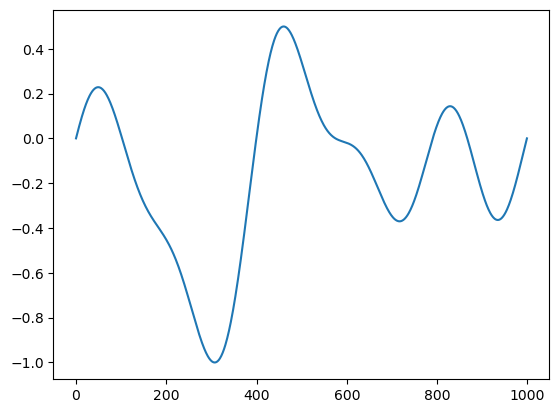

In [50]:
# Visualise first example in batch
plt.plot(target_sinusoidal_outputs[0])

In [51]:
# Generate random input spikes
# dimentions: [batch=1, time_steps=1000, n_in=100]
frozen_poisson_noise_input = np.random.rand(params['n_batch'], params['seq_len'], params['n_in']) < dt * input_f0  # why sampling period * input frequency? = [spikes]
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )
print(input_spikes.shape)

torch.Size([1, 1000, 100])


Text(0.5, 1.0, 'Input spikes')

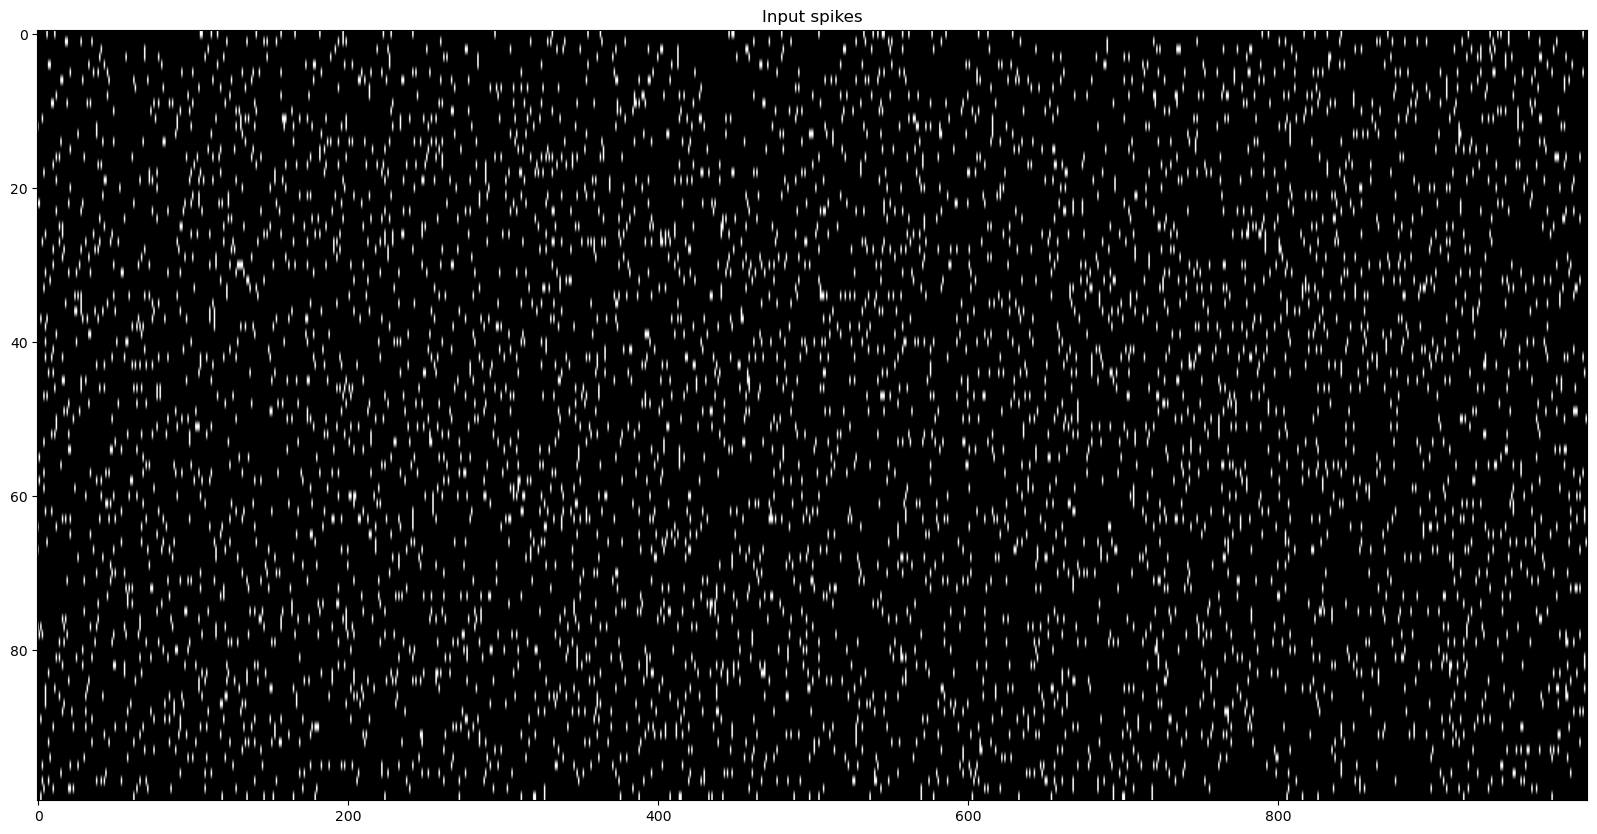

In [52]:
plt.figure(figsize=(20,10))
plt.imshow(input_spikes[0, :].T, cmap="gray", aspect="auto")
plt.title("Input spikes")

### Create DataLoader

`TODO:`

## Define Network

For now, feed each frame one by one to network, flattening the polarities (ON and OFF events)

In [53]:
TAU_MEM = 20e-3  # 50 ms
TAU_OUT = 20e-3  # 20 ms
GAMMA = 0.3
DT = 1e-3  # 1s TODO: Find appropriate time constants and timestep size
THRESHOLD = 1.0
NUM_STEPS = params["seq_len"]

NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
NUM_RECS= 64  # Design choice, number of recurrent neurons
NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
CLASSIFICATION = False
REGULARIZE = True
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
check_gradients = True

NUM_INPUTS: 100, NUM_HIDDENS: 64, NUM_OUTPUTS: 1


In [54]:
# TAU_MEM = 20  # 50 ms
# TAU_OUT = 20  # 20 ms
# GAMMA = 0.3
# DT = 1  # 1ms TODO: Find appropriate time constants and timestep size
# THRESHOLD = 1.0
# NUM_STEPS = params["seq_len"]

# NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
# NUM_RECS= 64  # Design choice, number of recurrent neurons
# NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
# CLASSIFICATION = False
# REGULARIZE = True
# print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# check_gradients = True

## Hardcoded network

In [55]:
# Define pseudo-derivative to tackle non-differentiability of the spike function

class SpikeFunction(torch.autograd.Function):
    """Applies Heaviside function in forward pass,
    and pseudo-derivative in backward pass.
    """
    @staticmethod
    def forward(ctx, input: torch.Tensor, threshold: float, damping_factor: float = 0.3):
        """Forward pass: compute activation for each input element (voltage).
        Parameters:
            ctx: context object to stash information for backward pass.
            input: input tensor (membrane voltages)
            threshold: firing threshold
            damping_factor: damping factor for pseudo-derivative
        Returns:
            output tensor (spikes)
        """
        ctx.save_for_backward(input)
        ctx.threshold = threshold  # threshold is not a Tensor
        ctx.damping_factor = damping_factor
        return input.gt(threshold).float()

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        input, = ctx.saved_tensors
        threshold, damping_factor = ctx.threshold, ctx.damping_factor
        grad_input = None

        if ctx.needs_input_grad[0]:
            pseudo_deriv = damping_factor/ threshold * torch.maximum(torch.tensor([0]), 1-torch.abs((input-threshold)/threshold))
            # Element-wise multiplication
            grad_input = grad_output.mul(pseudo_deriv)
        return grad_input, None, None
    
spike_fn = SpikeFunction.apply

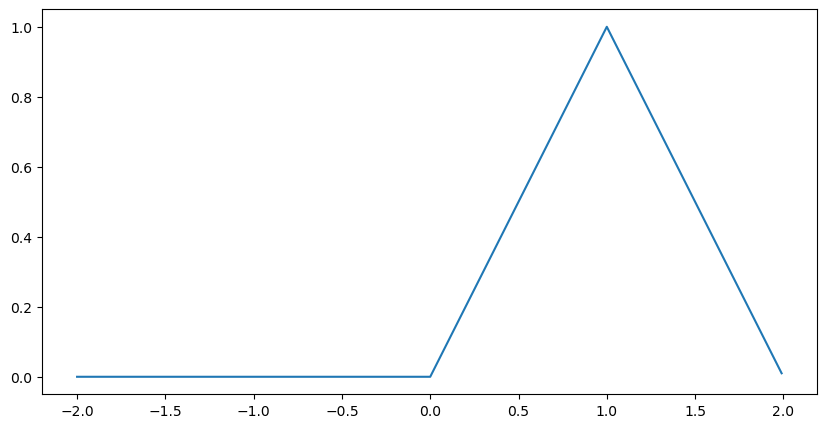

In [66]:
voltage = torch.tensor(np.arange(-2, 2, 0.01))
damping_factor = 0.3
threshold = 1
psi = damping_factor/ threshold * torch.maximum(torch.tensor([0]), 1-torch.abs((voltage-threshold)/threshold))

plt.figure(figsize=(10, 5))
plt.plot(voltage, psi.detach())


In [56]:
from hw_aware_eprop.utils import exp_convolve, shift_by_one_time_step

In [57]:
import torch.nn.functional as F

class RSNN(nn.Module):
    """Simple RSNN as in e-prop paper.
    I.e. Inputs -> Recurrent LIF Neurons -> Output LIF Neurons
    """
    def __init__(self, num_inputs: int, num_rec: int, num_outputs: int, classification: bool, tau_mem: float, 
                 tau_out: float, dt, gamma: float, threshold: float, device, reg_target_freq: float=10,
                reg_coeff: float=0.1, lr: float=1e-4, num_timesteps=3, w_init_gain: list[float]=[1.0, 1.0, 1.0],
                check_gradients: bool=False, learn_bias: bool=False, regularize: bool=False):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from torch.nn.Module

        self.device = device
        self.check_gradients = check_gradients
        self.learn_bias = learn_bias
        self.regularize = regularize

        # Optimiser Hyperparameters
        self.lr = lr
        if reg_target_freq is not None:
            self.reg_target_freq = reg_target_freq
        if reg_coeff is not None:
            self.reg_coeff = reg_coeff

        # SNN Hyperparameters
        self.tau_mem = tau_mem                  # Decay time constant for recurrent membrane potentials
        self.tau_out = tau_out                  # Decay time constant for output membrane potentials
        self.dt = dt                            # Timestep size
        self.alpha = np.exp(-dt/tau_mem)        # Recurrent membrane potential decay rate
        self.gamma = gamma                      # Constant in pseudo-deriv
        self.kappa = np.exp(-dt/tau_out)        # Output membrane potential decay rate
        self.threshold = threshold              # Membrane voltage threshold

        self.T = num_timesteps                  # Number of timesteps per example (3 for NMNIST saccades)

        # Architecture params
        self.n_in = num_inputs
        self.n_rec = num_rec
        self.n_out = num_outputs
        self.classification = classification

        # Declare network weights
        self.w_in = nn.Parameter(torch.Tensor(self.n_rec, self.n_in))
        # Disable self connections in recurrent layer
        w_rec = torch.Tensor(self.n_rec, self.n_rec) * (1-torch.eye(self.n_rec, self.n_rec, device=self.device))
        self.w_rec = nn.Parameter(w_rec)
        self.w_out = nn.Parameter(torch.Tensor(self.n_out, self.n_rec))
        # self.output_bias = 0.
        self.b_out = nn.Parameter(torch.zeros(self.n_out)) if self.learn_bias else 0.

        # Create mask for recurrent weights
        self.w_rec_mask = 1-torch.eye(self.n_rec, self.n_rec, device=self.device)

        w_init_gain = 7.
        self.init_params(w_init_gain)

        # Initialise manual grad attributes
        self.w_in_grad = torch.zeros_like(self.w_in)
        self.w_rec_grad = torch.zeros_like(self.w_rec)
        self.w_out_grad = torch.zeros_like(self.w_out)
        if self.learn_bias:
            self.b_out_grad = torch.zeros_like(self.b_out)  

    def init_params(self, gain):
        """Perform He Initialisation on network parameters"""
        # Try Xavier init with scale rel to decay rate
        weight_scale = gain*(1 - self.alpha)  # Can multiply this as well
        nn.init.normal_(self.w_in, mean=0, std=weight_scale/np.sqrt(self.n_in))
        nn.init.normal_(self.w_rec, mean=0, std=weight_scale/np.sqrt(self.n_rec))
        nn.init.normal_(self.w_out, mean=0, std=weight_scale/np.sqrt(self.n_rec))

    def reset_network(self):
        """Set membrane potentials, spikes, and gradients to zero.
        Used after feeding in an example, to prepare for next.
        """
        # Recurrent hidden state and output spikes
        self.v = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)
        self.z = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)

        # Output hidden state
        self.vo = torch.zeros(self.T, self.BS, self.n_out).to(self.device)
        # TODO: Can use output spikes as well

        # Mask recurrent weights
        # self.w_rec = self.w_rec.clone() * self.w_rec_mask

        # Gradients
        self.w_in_grad = torch.zeros_like(self.w_in)
        self.w_rec_grad = torch.zeros_like(self.w_rec)
        self.w_out_grad = torch.zeros_like(self.w_out)
        if self.learn_bias:
            self.b_out_grad = torch.zeros_like(self.b_out)

    def forward(self, x: torch.Tensor):
        """Feed example through RSNN
        Parameters:
            x: Inputs to RSNN, [T, BS, features...]
        Returns:
            yo: Output probabilities, [T, BS, num_outputs]
            vo: Output membrane potentials, [T, BS, num_outputs]
        """

        # Extract batch size and flatten x features
        self.BS= x.shape[1]  # x shape: [T, BS, features...]
        # x = x.flatten(start_dim=2)  # Flatten after [time, batch_size, ...]

        # Reset membrane potentials and gradients
        self.reset_network()

        # Ensure no self connections
        # with torch.no_grad():
        # self.w_rec.data = self.w_rec.data * (1 - torch.eye(self.n_rec, self.n_rec, device=self.device))

        # Debug
        # print(f"v: {self.v.shape}, v[t]: {self.v[0].shape}")
        # print(f"x: {x.shape}, x[t]: {x[0].shape}")

        # self.z.detach()

        # Allocate new memory to avoid inplace operations
        v: list[torch.Tensor] = []
        z: list[torch.Tensor] = []
        vo: list[torch.Tensor] = []

        # Add initial membrane potentials
        v.append(self.v[0])
        z.append(self.z[0])
        vo.append(self.vo[0])

        
        for t in range(self.T - 1):
            z[t] = z[t].detach()
            # self.v[t+1] = (self.alpha*self.v[t] + self.z[t].mm(self.w_rec.t()) + x[t].mm(self.w_in.t()) - self.z[t]*self.threshold)  # z[t], x[t] row vectors, i.e. [1, N_REC]
            # self.v[t+1].copy_()
            # v_t = self.alpha*v[t] + z[t].mm((self.w_rec).t()) + x[t].mm(self.w_in.t()) - z[t].detach()*self.threshold
            v_t = self.alpha*v[t] + torch.matmul(z[t], (self.w_rec * self.w_rec_mask).t()) + torch.matmul(x[t], (self.w_in.t()))

            # print(f"self.z[t].mm(self.w_rec.t()): {self.z[t].mm(self.w_rec.t()).shape}")
            # print(f"x[t].mm(self.w_in.t()): {x[t].mm(self.w_in.t()).shape}")
            # print(f"self.v[t+1]: {self.v[t+1].shape}")

            # self.z[t+1] = (self.v[t+1] > self.threshold).float()
            # self.z[t+1] = SpikeFunction.apply(self.v[t+1], self.threshold, self.gamma)
            # self.z[t+1] = spike_fn(v_t, self.threshold, self.gamma)
            z_t = SpikeFunction.apply(v_t, self.threshold, self.gamma)

            
            # print(f"self.z[t+1]: {self.z[t+1].shape}")
            # print(f"self.z[t].mm(self.w_out.t()): {self.z[t].mm(self.w_out.t()).shape}")

            # self.vo[t+1] = self.kappa*self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias
            # self.vo[t+1].copy_(self.kappa * self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias)
            vo_t = self.kappa*vo[t] + z[t].mm(self.w_out.t()) + self.b_out

            # Reset membrane potentials of neurons that spiked
            v_t = v_t - z[t].detach()*self.threshold

            v.append(v_t)
            z.append(z_t)
            vo.append(vo_t)
        
        # Set vo and v to tensors
        self.v = torch.stack(v, dim=0)  # [T, BS, N_REC]
        self.z = torch.stack(z, dim=0)
        self.vo = torch.stack(vo, dim=0)
        
        # Apply softmax for classification
        if self.classification:
            self.yo = F.softmax(self.vo, dim=2)  # vo shape: [T, BS, num_outputs]
        else:  # Regression on membrane voltage
            self.yo = self.vo

        return self.yo, self.vo
    
    def calc_loss(self, vo, y_target) -> torch.Tensor:
        """Calculate model loss (using output membrane potentials)

        Parameters:
            vo: Output membrane potentials [T, BS, NUM_OUTPUTS]
            y_target: In case of CE loss, index of correct class (not one-hot),
                        size, [BATCH_SIZE].
                        If MSE, target regression value, size [T, BS, n_out]
        Returns:
            loss_val: scalar
        
        N.B. Usually must y_target.swapaxes(1,0) before passing to this method,
        since dataloader will give [BS, T, ...]
        
        """
        # print(f"vo: {vo.shape}")
        # print(f"y_target: {y_target.shape} should be {[1]}")
        # print(f"CELoss: {F.mse_loss(vo[0], y_target[0, :, :]).shape}")
        loss_val = torch.zeros((1), dtype=float, device=self.device)
        for t in range(self.T):
            if self.classification:
                loss_val += F.cross_entropy(vo[t], y_target)
            else:
                loss_val += F.mse_loss(vo[t], y_target[t, :, :], reduce="sum")
        if self.regularize:
            avg_firing_freq = torch.mean(self.z, dim=(0,1)) / self.dt
            firing_target_error = self.reg_target_freq - avg_firing_freq
            reg_loss = 0.5* self.reg_coeff * torch.sum(firing_target_error**2)
            loss_val += reg_loss
        return loss_val

    
    def calc_grads(self, x: torch.Tensor, yo: torch.Tensor, y_target: torch.Tensor):
        """Calculate learning signals, eligility traces and set .grad attributes"""

        # Surrogate derivative, N.B. gamma is gamma_d/v_th
        psi = self.gamma/self.threshold*torch.maximum(torch.zeros_like(self.v), 1-torch.abs((self.v-self.threshold)/self.threshold))
        

        # Pseudocode:
        # eligibility_vectors = low pass filtered inputs
        # eligibility_traces = psi * eligibility_vectors
        # Gradients = Learning signal * eligibility_traces

        # Eligibility traces for input and reccurent weights
        alpha_conv  = torch.tensor([self.alpha ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_in    = F.conv1d(x.permute(1,2,0), alpha_conv.expand(self.n_in ,-1,-1), padding=self.T, groups=self.n_in )[:,:,1:self.T+1].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_in , n_t 
        elig_trace_in    = torch.einsum('tbr,brit->brit', psi, elig_vec_in)                                                                                                                          #n_b, n_rec, n_in , n_t 
        elig_vec_rec   = F.conv1d(self.z.permute(1,2,0), alpha_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:, :self.T].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_rec, n_t
        elig_trace_rec   = torch.einsum('tbr,brit->brit', psi, elig_vec_rec)

        # Eligibility vectors for output weights
        kappa_conv = torch.tensor([self.kappa ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_out = F.conv1d(self.z.permute(1,2,0), kappa_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:,1:self.T+1]

        # Low pass filtered eligibility traces for input and recurrent weights
        e_bar_in = F.conv1d(elig_trace_in.reshape(self.BS, self.n_in *self.n_rec, self.T), kappa_conv.expand(self.n_in*self.n_rec,-1,-1), padding=self.T, groups=self.n_in *self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_in ,self.T)   #n_b, n_rec, n_in , n_t
        e_bar_rec = F.conv1d(elig_trace_rec.reshape(self.BS,self.n_rec*self.n_rec,self.T), kappa_conv.expand(self.n_rec*self.n_rec,-1,-1), padding=self.T, groups=self.n_rec*self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_rec,self.T)   #n_b, n_rec, n_rec, n_t

        # Learning signals
        # TODO: yo is for every timestep, y_target needs to be for every time, and one-hot coded [T, BS, NUM_OUT]
        if self.classification:
            y_target = F.one_hot(y_target.long(), num_classes=self.n_out)
        error = yo - y_target
        L = torch.einsum('tbo,or->brt', error, self.w_out)

        # Regularization loss
        if self.regularize:
            avg_firing_freq = torch.mean(self.z, dim=(0,1)) / self.dt  # in Hz, = probability/dt
            firing_target_error = -(self.reg_target_freq - avg_firing_freq)
            e_avg_in = torch.mean(elig_trace_in, dim=(0,3))
            e_avg_rec = torch.mean(elig_trace_rec, dim=(0,3))
            # grad of reg loss wrt w_ji is error_j * elig_trace_ji avgd over time
            dRegLoss_dWin = torch.einsum("j,ji->ji", firing_target_error, e_avg_in)  # [n_rec, n_in]
            dRegLoss_dWrec = torch.einsum("j,ji->ji", firing_target_error, e_avg_rec) # [n_rec, n_rec]
            # print(f"avg_firing_freq: {avg_firing_freq}")
            # print(f"firing_target_error: {firing_target_error}")
        else:
            dRegLoss_dWin = 0.
            dRegLoss_dWrec = 0.

        # TODO: Only compute network updates on timestepswhen target is present?

        # Update weight .grad attributes
        w_in_grad = torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3)) 
        w_rec_grad = torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_rec,-1) * e_bar_rec, dim=(0,3))
        w_out_grad = torch.einsum('tbo,brt->or', error, elig_vec_out)
        # TODO: Add flag to toggle gradient checking, if false directly set .grad attributes
        if self.check_gradients:
            self.w_in_grad  = w_in_grad + self.reg_coeff * dRegLoss_dWin  # Add regularization loss
            print(f"reg weighting in: {self.reg_coeff * dRegLoss_dWin/ self.w_in_grad}")
            self.w_rec_grad = w_rec_grad * self.w_rec_mask + self.reg_coeff * dRegLoss_dWrec  # Only update non-self connections
            print(f"reg weighting rec: {self.reg_coeff * dRegLoss_dWrec/ self.w_rec_grad}")
            self.w_out_grad = w_out_grad
            if self.learn_bias:
                self.b_out_grad = torch.sum(error, dim=(0,1))
        else:
            self.w_in.grad += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3))
            self.w_rec.grad += w_rec_grad * self.w_rec_mask
            self.w_out.grad += torch.einsum('tbo,brt->or', error, elig_vec_out)
            if self.learn_bias:
                self.b_out.grad += torch.sum(error, dim=(0,1))

    def calc_grads_fm(self, x, output_error, average_firing_error):
        v_scaled = (self.v-self.threshold)/self.threshold
        psi = self.gamma/self.threshold*torch.maximum(torch.zeros_like(self.v), 1-torch.abs(v_scaled))
        z_previous_time = shift_by_one_time_step(self.z)

        elig_vec_in = exp_convolve(x, self.alpha)
        elig_vec_rec = exp_convolve(z_previous_time, self.alpha)
        elig_vec_out = exp_convolve(self.z, self.kappa)

        # Eligibility traces, note diff between time first here and batch first in fm
        elig_trace_in = psi[:,:,None,:] * elig_vec_in[:,:,:,None]  # T, BS, 1, N_REC * T, BS, N_IN, 1
        elig_trace_rec = psi[:,:,None,:] * elig_vec_rec[:,:,:,None]  # T, BS, 1, N_REC * T, BS, N_REC, 1

        # Low pass filtered eligibility traces
        e_bar_in = exp_convolve(elig_trace_in, self.kappa)
        e_bar_rec = exp_convolve(elig_trace_rec, self.kappa)

        # Learning signals
        L = torch.einsum('tbo,or->tbr', output_error, self.w_out)
        print(f"L: {L.shape}")

        # e-prop gradients
        # dloss_dw_in = 
        dloss_dw_in = torch.sum(L[:, :, None, :] * e_bar_in, axis=(0, 1))
        dloss_dw_rec = torch.sum(L[:, :, None, :] * e_bar_rec, axis=(0, 1))
        dloss_dw_out = torch.sum(output_error[:, :, None, :] * elig_vec_out[:, :, :, None], axis=(0, 1))

        # Regularisation gradients
        # dreg_dw_in = torch.einsum("j,ji->ji", average_firing_error, torch.mean(elig_trace_in, axis=(0, 3)))
        dreg_dw_in = average_firing_error * torch.mean(elig_trace_in, axis=(0, 1))
        dreg_dw_rec = average_firing_error * torch.mean(elig_trace_rec, axis=(0, 1))

        # Combine gradients
        self.w_in_grad = torch.transpose(dloss_dw_in + self.reg_coeff * dreg_dw_in, 0, 1)
        w_rec_grad = dloss_dw_rec + self.reg_coeff * dreg_dw_rec
        self.w_rec_grad = torch.transpose(w_rec_grad * self.w_rec_mask, 0, 1)
        self.w_out_grad = torch.transpose(dloss_dw_out, 0, 1)

    
    def update_weights(self):
        """Manually update weights using _grad attributes.

        Simply Vanilla SGD for now.
        """
        with torch.no_grad():
            self.w_in  -= self.lr * self.w_in_grad
            self.w_rec -= self.lr * self.w_rec_grad
            self.w_out -= self.lr * self.w_out_grad
            if self.learn_bias:
                self.b_out -= self.lr * self.b_out_grad
    
    def grad_error(self, loss_val: torch.Tensor):
        """Calculate gradient error between eprop and bptt"""
        params = [self.w_in, self.w_rec, self.w_out]
        grad_bptt = torch.autograd.grad(loss_val, params, create_graph=True, allow_unused=True)
        with torch.no_grad():
            grad_eprop = [self.w_in_grad, self.w_rec_grad, self.w_out_grad]
            if self.learn_bias:
                grad_eprop.append(self.b_out_grad)
            # grad_error = torch.stack([((grad_bptt[i] - grad_eprop[i])).sum() for i in range(len(grad_bptt))])
            grad_error = []
            for i in range(len(grad_bptt)):
                if grad_bptt[i] is None:
                    grad_error.append(torch.zeros_like(grad_eprop[i]))
                else:
                    grad_error.append(grad_bptt[i] - grad_eprop[i])
        
        return grad_error

net = RSNN(num_inputs=NUM_INPUTS,
           num_rec=NUM_RECS,
           num_outputs=NUM_OUTPUTS,
           classification=CLASSIFICATION,
           tau_mem=TAU_MEM,
           tau_out=TAU_OUT,
           dt=DT,
           gamma=GAMMA,
           threshold=THRESHOLD,
           device=device,
           regularize=REGULARIZE,
           num_timesteps=params["seq_len"],
           lr=params["learning_rate"],
           check_gradients=check_gradients
).to(device)

### Print network diagnostics

In [21]:
net.alpha, net.kappa

(0.951229424500714, 0.951229424500714)

In [22]:
net.w_in.sum(dim=1)

tensor([-0.4307, -0.1723, -0.0258,  0.2127, -0.1810,  0.6237,  0.3981, -0.1130,
         0.2859,  0.2263,  0.0215, -0.7662, -0.1596, -0.0560,  0.1847, -0.0575,
         0.0258,  0.3585,  0.1136, -0.2050,  0.0089, -0.0629, -0.3592, -0.1700,
        -0.7320, -0.5353, -0.3221,  0.1973, -0.5877, -0.3679, -0.1313,  0.3579,
        -0.1143, -0.2090, -0.1630,  0.4367, -0.2417,  0.3426,  0.3505,  0.3485,
        -0.7182, -0.0696, -0.4722, -0.1599,  0.2663, -0.7710, -0.4258,  0.2354,
         0.1205, -0.0596, -0.1006,  0.6682,  0.2562, -0.2796,  0.0627,  0.0490,
         0.5180, -0.0277, -0.2703,  0.0798,  0.3296, -0.3979,  0.3540,  0.1207],
       grad_fn=<SumBackward1>)

In [23]:
net.w_rec.sum(dim=1)

tensor([ 0.0696,  0.0677,  0.4073,  0.1627,  0.3108,  0.2373,  0.2958,  0.4099,
         0.2845,  0.2762, -0.8353, -0.1314,  0.2616, -0.5778, -0.5152,  0.1004,
        -0.0148,  0.2996, -0.2689,  0.1449,  0.2631,  0.7893,  0.0741,  0.0060,
        -0.1070, -0.1613, -0.1824,  0.2792, -0.0473, -0.0096,  0.0995, -0.2461,
         0.3967,  0.2585,  0.1080, -0.0284, -0.4189,  0.6971, -0.1050,  0.0065,
         0.3045, -0.4743, -0.3199,  0.1015,  0.4416,  0.4234, -0.5303, -0.2109,
        -0.2171, -0.1165,  0.5256,  0.0082,  0.1300,  0.4280,  0.1732,  0.0867,
         0.7137,  0.0899,  0.1669,  0.1822, -0.4491, -0.9560,  0.2543,  0.1577],
       grad_fn=<SumBackward1>)

In [24]:
net.w_out.sum(dim=1)

tensor([0.3662], grad_fn=<SumBackward1>)

## Define accuracy metrics

In [25]:
def train_printer(epoch, loss_hist):
    print(f"Epoch {epoch}")
    print(f"Train Set Loss: {loss_hist[epoch]:.2f}")
    print("\n")

## Debug: single epoch of training

In [58]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [59]:
# with torch.autograd.set_detect_anomaly(True):
data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

# Forward pass
preds, vo = net(data)

# Backward pass
loss_val = net.calc_loss(vo, targets)
# loss_val = torch.zeros((1), dtype=float)
# for t in range(1000):
#     loss_val += F.mse_loss(vo[t], targets[t, :, :])

print(f"Loss before training: {loss_val.item()}")
optimizer.zero_grad(set_to_none=False)
# print(torch.autograd.grad(loss_val, net.parameters()))

# net.calc_grads(data, preds, targets)
output_error = preds - targets
average_firing_error = net.reg_target_freq - torch.mean(net.z, dim=(0,1)) / net.dt
net.calc_grads_fm(data, output_error, average_firing_error)

# Check gradient error
# grad_error = net.grad_error(loss_val)
# print(f"Gradient error: {grad_error}")
true_grads = torch.autograd.grad(loss_val, net.parameters(), create_graph=True, allow_unused=True)
print(f"e-prop shapes: {net.w_in_grad.shape}, {net.w_rec_grad.shape}, {net.w_out_grad.shape}")
print(f"BPTT shapes: {true_grads[0].shape}, {true_grads[1].shape}, {true_grads[2].shape}")
print(f"True gradients: {true_grads}")
print(f"e_prop gradients: {net.w_in_grad}, {net.w_rec_grad}, {net.w_out_grad}")
e_prop_grads = [net.w_in_grad, net.w_rec_grad, net.w_out_grad]

# Print gradient errors
for i in range(len(true_grads)):
    if true_grads[i] is None:
        print(f"Gradient error for {i}: None")
    else:
        print(f"Gradient error for {i}: {torch.sum(true_grads[i] - e_prop_grads[i])}")
        # print(f"Scaling factor for {i}: {true_grads[i] / e_prop_grads[i]}")

# if net.check_gradients:
#     net.update_weights()
# else:
#     optimizer.step()

/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Loss before training: 452.7875449011017
L: torch.Size([1000, 1, 64])
e-prop shapes: torch.Size([64, 100]), torch.Size([64, 64]), torch.Size([1, 64])
BPTT shapes: torch.Size([64, 100]), torch.Size([64, 64]), torch.Size([1, 64])
True gradients: (tensor([[ 0.0915,  0.0533,  0.0357,  ...,  0.0264,  0.0327,  0.0241],
        [-0.1425, -0.0830, -0.0556,  ..., -0.0412, -0.0509, -0.0376],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0764, -0.0445, -0.0298,  ..., -0.0221, -0.0273, -0.0201]],
       grad_fn=<AddBackward0>), tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0115, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000

In [ ]:
dloss_dw_in = torch.sum(L[:, :, None, :] * e_bar_in, axis=(0, 1))

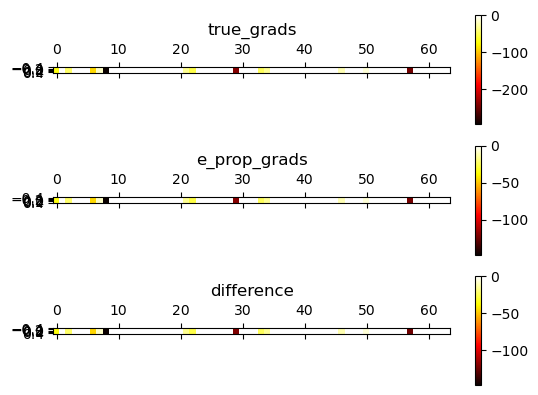

In [33]:
from matplotlib.colors import LogNorm
norm=None
# Plot heatmaps of true_grads and e_prop_grads tensor slices
fig, axs = plt.subplots(3, 1)

# Plot true_grads heatmap
im1 = axs[0].matshow(true_grads[2].detach(), cmap="hot", norm=norm)
axs[0].set_title("true_grads")

# Plot e_prop_grads heatmap
im2 = axs[1].matshow(e_prop_grads[2].detach(), cmap="hot", norm=norm)
axs[1].set_title("e_prop_grads")

# Plot difference heatmap
im3 = axs[2].matshow(true_grads[2].detach() - e_prop_grads[2].detach(), cmap="hot", norm=norm)
axs[2].set_title("difference")

# Add colorbars
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])

# Show the plot
plt.show()

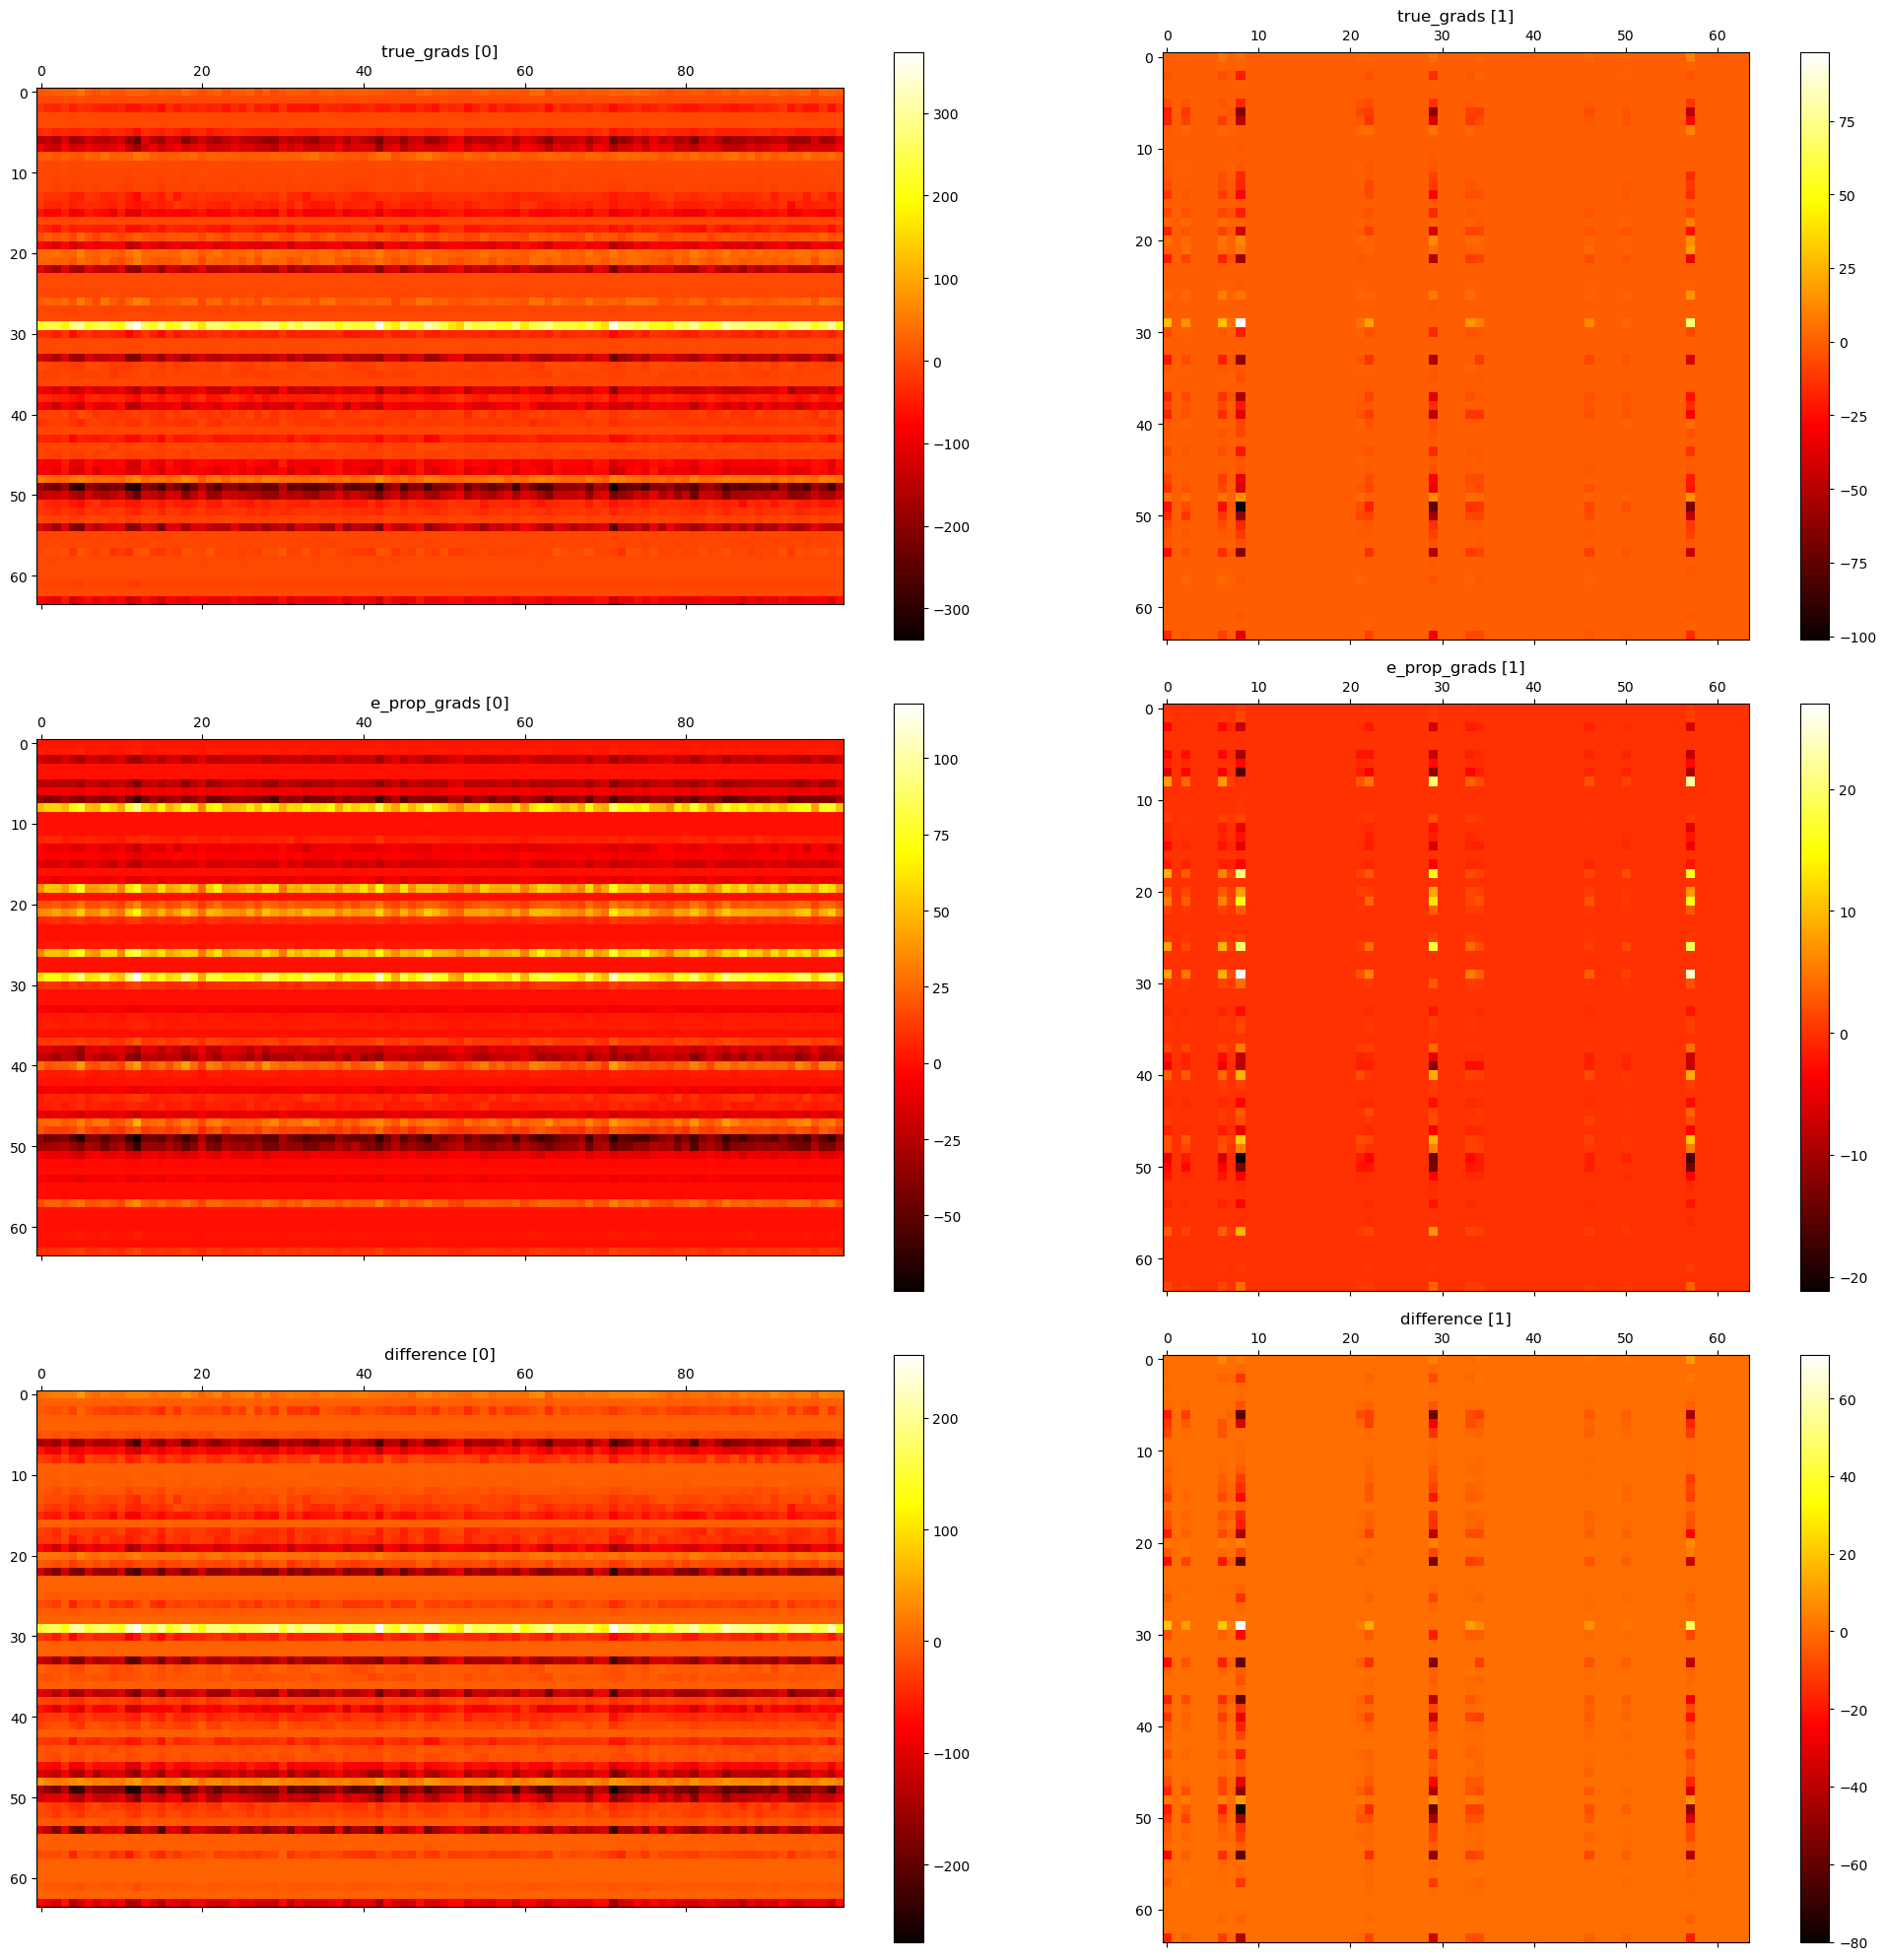

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

# Plot true_grads heatmap for [0] slice
im1 = axs[0, 0].matshow(true_grads[0].detach(), cmap="hot", norm=norm)
axs[0, 0].set_title("true_grads [0]")

# Plot e_prop_grads heatmap for [0] slice
im2 = axs[1, 0].matshow(e_prop_grads[0].detach(), cmap="hot", norm=norm)
axs[1, 0].set_title("e_prop_grads [0]")

# Plot difference heatmap for [0] slice
im3 = axs[2, 0].matshow(true_grads[0].detach() - e_prop_grads[0].detach(), cmap="hot", norm=norm)
axs[2, 0].set_title("difference [0]")

# Plot true_grads heatmap for [1] slice
im4 = axs[0, 1].matshow(true_grads[1].detach(), cmap="hot", norm=norm)
axs[0, 1].set_title("true_grads [1]")

# Plot e_prop_grads heatmap for [1] slice
im5 = axs[1, 1].matshow(e_prop_grads[1].detach(), cmap="hot", norm=norm)
axs[1, 1].set_title("e_prop_grads [1]")

# Plot difference heatmap for [1] slice
im6 = axs[2, 1].matshow(true_grads[1].detach() - e_prop_grads[1].detach(), cmap="hot", norm=norm)
axs[2, 1].set_title("difference [1]")

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0])
fig.colorbar(im2, ax=axs[1, 0])
fig.colorbar(im3, ax=axs[2, 0])
fig.colorbar(im4, ax=axs[0, 1])
fig.colorbar(im5, ax=axs[1, 1])
fig.colorbar(im6, ax=axs[2, 1])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [35]:
with torch.no_grad():
    preds, vo = net(data)
    loss = net.calc_loss(vo, targets)
    print(f"Loss after training: {loss}")


Loss after training: tensor([438.8331], dtype=torch.float64)


In [36]:
target_sinusoidal_outputs.shape, targets.shape, vo.shape

(torch.Size([1, 1000, 1]), torch.Size([1000, 1, 1]), torch.Size([1000, 1, 1]))

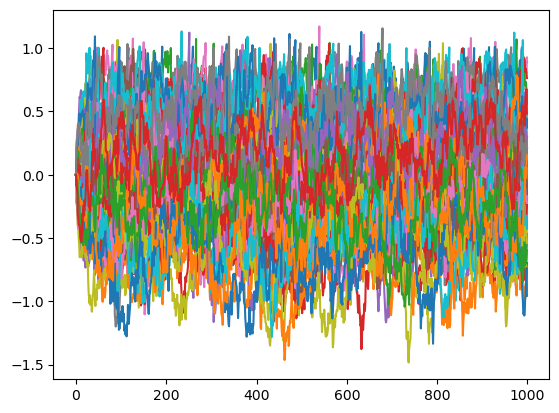

In [37]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.v[:,0].detach())

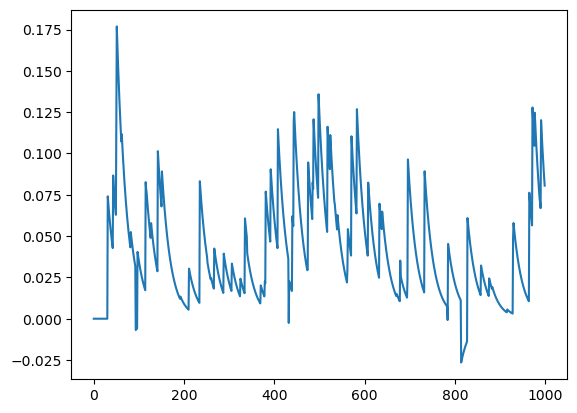

In [38]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.vo[:,0].detach())

## Training loop

Note slightly strange example:
- Our training set consists only of 1 example, (input_spikes, target_sinusoids)
- We shall train for 100 epochs on this example
- We then test on that example

In [39]:
print(input_spikes.shape, target_sinusoidal_outputs.shape)

torch.Size([1, 1000, 100]) torch.Size([1, 1000, 1])


In [40]:
LR = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [41]:
NUM_EPOCHS = 50
PRINT_EVERY_EPOCHS = 10
train_loss_hist = []
grad_errors = []
print(net.check_gradients)
# Outer training loop
for epoch in range(NUM_EPOCHS):
    # for data, targets in iter(dataloader))
    net.train()
    data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
    data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

    # Forward pass
    preds, vo = net(data)

    # Backward pass
    optimizer.zero_grad(set_to_none=False)
    loss = net.calc_loss(vo, targets)
    net.calc_grads(data, preds, targets)

    # Check gradient error
    # grad_errors.append(net.grad_error(loss))
    
    if net.check_gradients:
        net.update_weights()
    else:
        optimizer.step()

    # Store loss
    train_loss_hist.append(loss.item())

    # Print training statistics
    if epoch % PRINT_EVERY_EPOCHS == 0:
        train_printer(epoch, train_loss_hist)

True


reg weighting in: tensor([[ 8.6829e-09,  8.1913e-09,  9.9110e-09,  ...,  7.3262e-09,
          7.9386e-09,  8.1648e-09],
        [-4.2999e-03, -4.0500e-03, -4.7615e-03,  ..., -4.3234e-03,
         -4.6133e-03, -4.3681e-03],
        [ 7.3156e-04,  6.8580e-04,  7.9687e-04,  ...,  6.0781e-04,
          7.0266e-04,  6.5319e-04],
        ...,
        [-3.8535e-03, -2.6476e-03, -2.7502e-03,  ..., -2.7730e-03,
         -2.5141e-03, -2.3950e-03],
        [-7.3077e-03, -9.1005e-03, -9.6850e-03,  ..., -5.5498e-03,
         -7.9516e-03, -7.4775e-03],
        [-1.3550e-02, -1.3336e-02, -1.6240e-02,  ..., -1.1323e-02,
         -1.5255e-02, -1.1368e-02]], grad_fn=<DivBackward0>)
reg weighting rec: tensor([[ 1.0000e+00,         nan,  7.8266e-09,  ...,         nan,
                 nan,         nan],
        [-4.9933e-03,         nan, -4.2336e-03,  ...,         nan,
                 nan,         nan],
        [ 1.1065e-03,         nan,  1.0000e+00,  ...,         nan,
                 nan,         nan]

## Plot results

### Learning curves

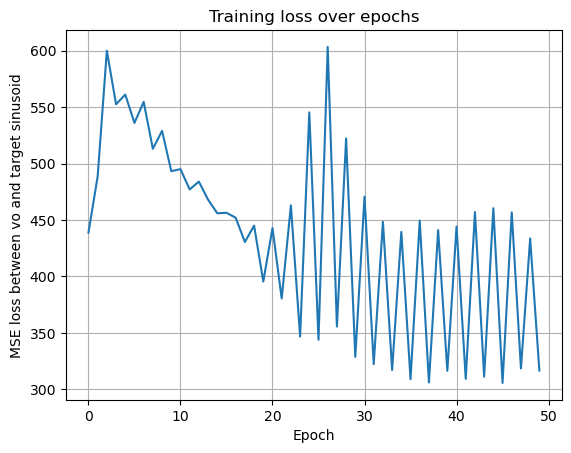

In [42]:
plt.title("Training loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE loss between vo and target sinusoid")
plt.plot(train_loss_hist)
# plt.ylim((0, 300))
plt.grid()

### Output membrane voltage

Text(0, 0.5, 'Membrane voltage')

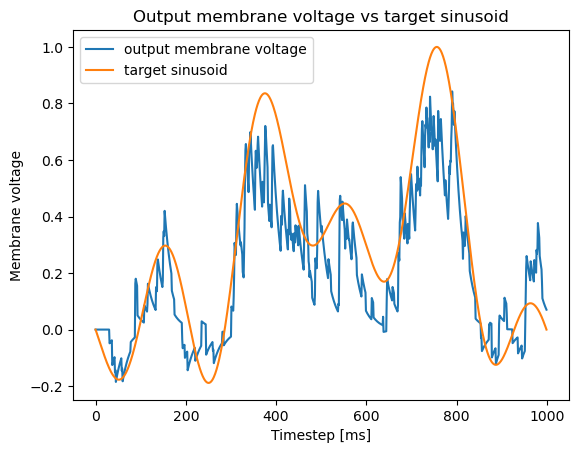

In [43]:
plt.plot(net.vo[:,0,0].detach(), label="output membrane voltage")
plt.plot(target_sinusoidal_outputs[0,:,0], label="target sinusoid")
plt.legend()
plt.title("Output membrane voltage vs target sinusoid")
plt.xlabel("Timestep [ms]")
plt.ylabel("Membrane voltage")

## Probe network

### Plot recurrent membrane potentials

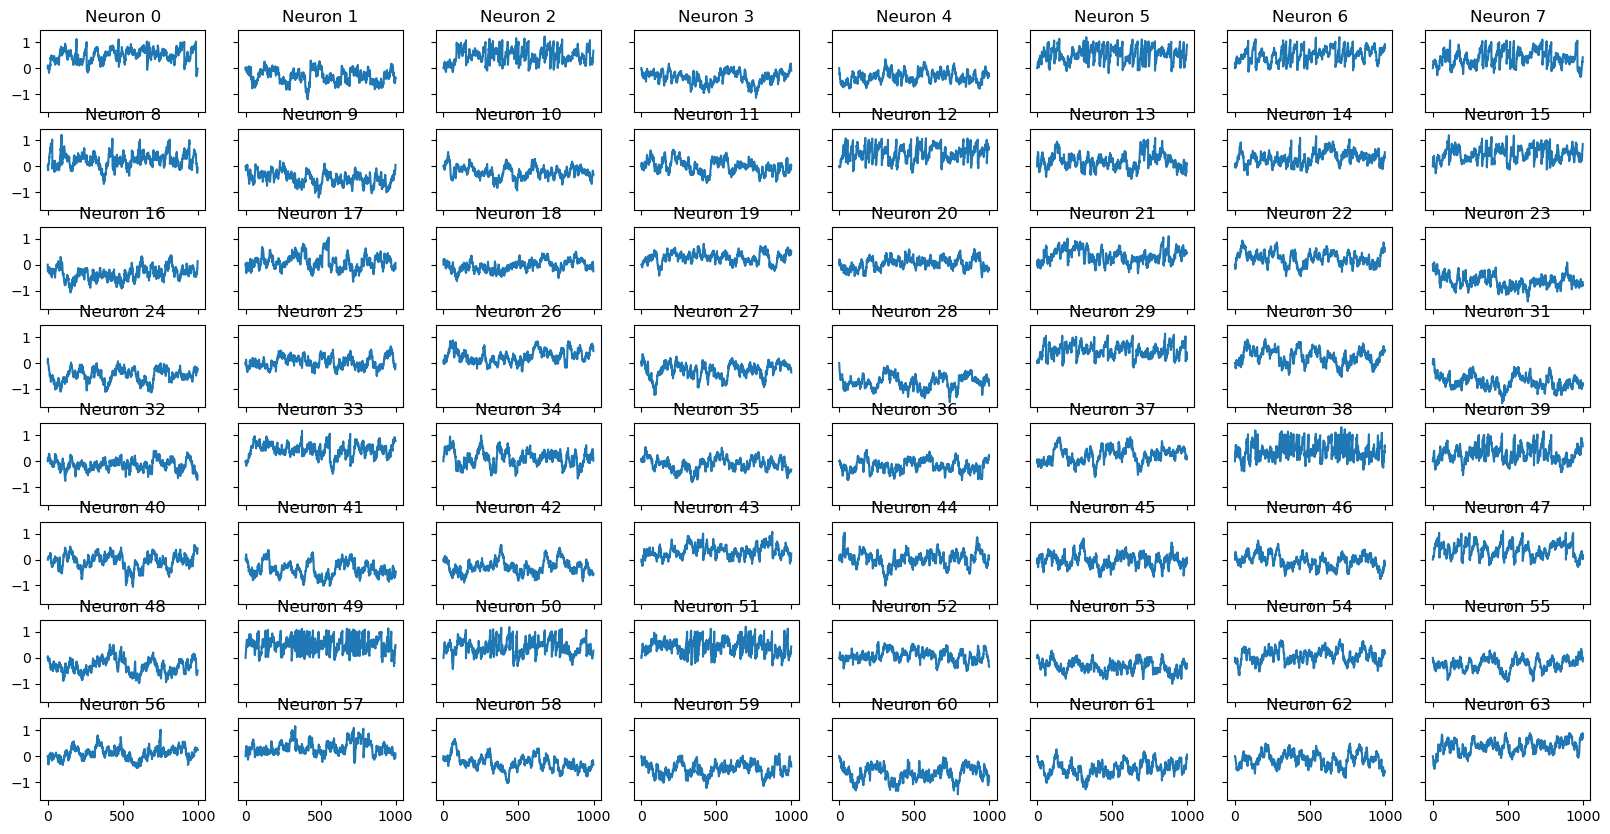

In [44]:
# Plot membrane voltage for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.v[:,0,i*8+j].detach(), label="recurrent membrane voltage")
        axs[i,j].set_title(f"Neuron {i*8+j}")
        # axs[i,j].legend()

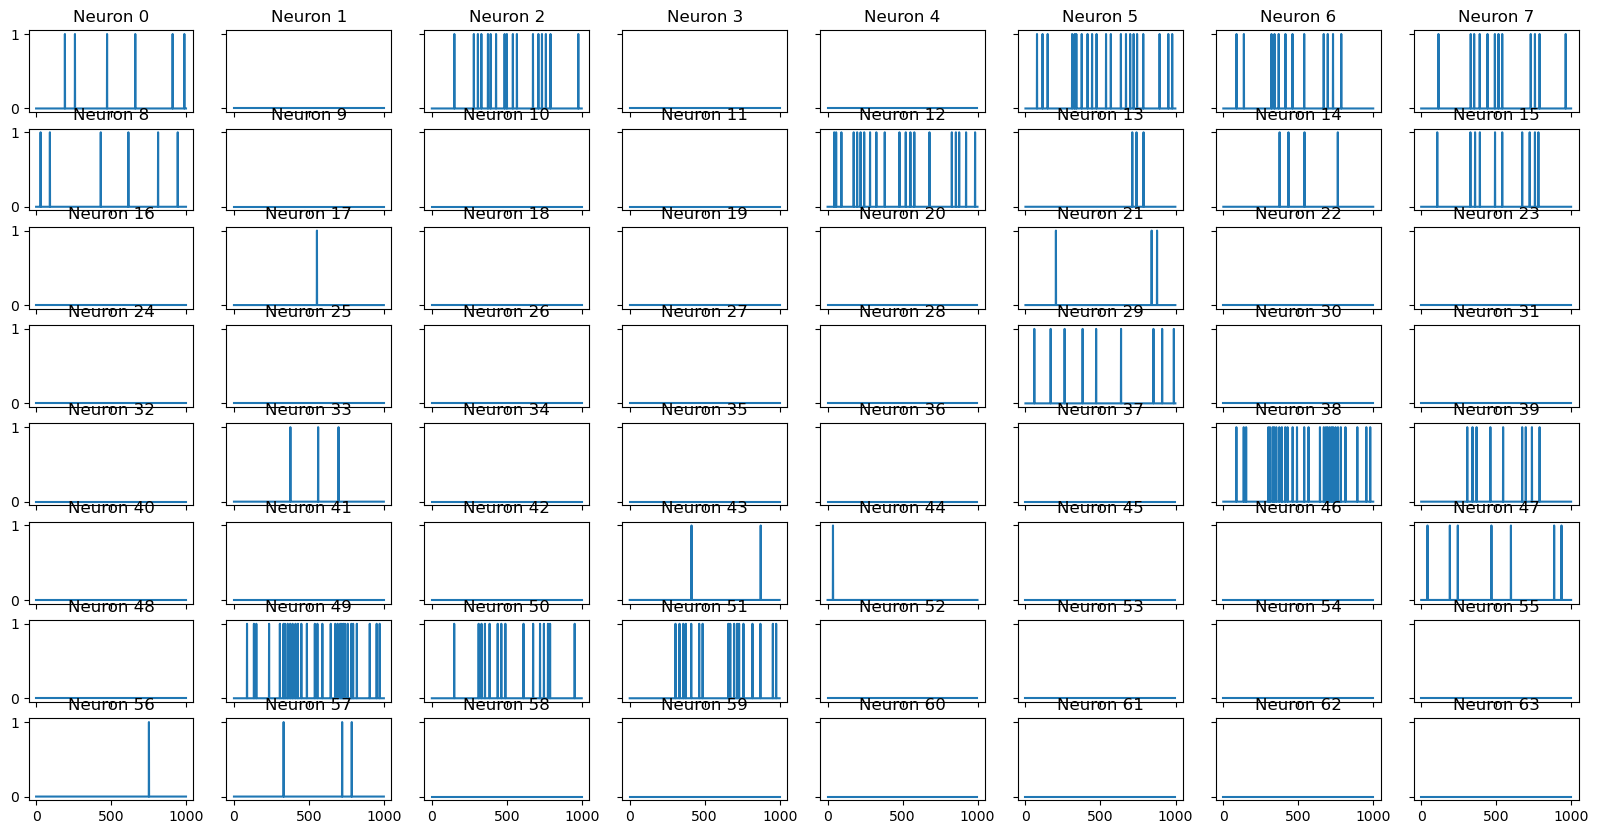

In [45]:
# Plot spikes for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.z[:,0,i*8+j].detach(), label="recurrent spikes")
        axs[i,j].set_title(f"Neuron {i*8+j}")

### Check self connections and their gradients

In [46]:
t = 20
in_error = torch.sum(grad_errors[t][1])
in_error, grad_errors[t][1]

(tensor(9926.7324),
 tensor([[-2.2105e-02,  0.0000e+00, -3.5100e+01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.3775e+00, -0.0000e+00, -4.8787e+00,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 5.9527e+01,  0.0000e+00, -1.0942e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 1.0062e-01,  0.0000e+00,  3.9073e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-5.2741e+00, -0.0000e+00, -1.1112e+01,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [-5.7406e+01, -0.0000e+00, -8.4119e+01,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00]]))

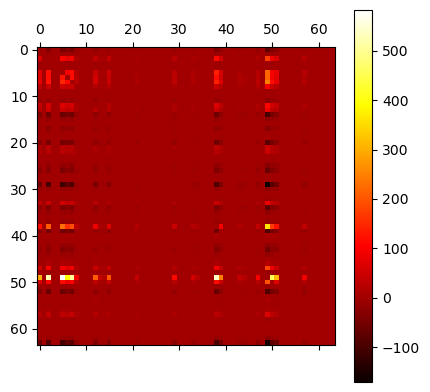

In [47]:
plt.matshow(grad_errors[t][1].detach(), cmap="hot", norm=norm)
plt.colorbar()

# Debug

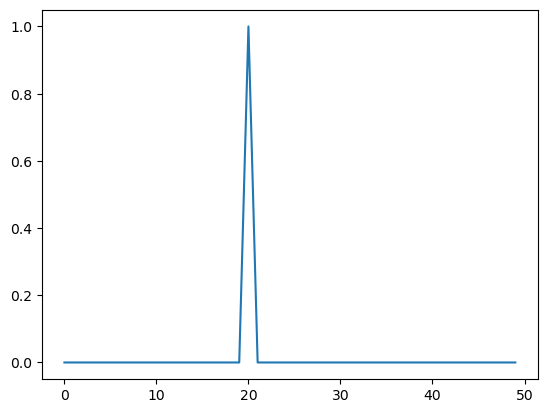

In [21]:
frozen_poisson_noise_input = np.random.rand(params['n_batch'], 50, 1) < dt * input_f0  # why sampling period * input frequency? = [spikes]
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )
plt.plot(input_spikes[0])

In [23]:
input_spikes.shape

torch.Size([1, 50, 1])

In [45]:
alpha = 0.9
target = torch.ones((1, 50, 1))
w_in = torch.ones((2, 1))
w_rec = torch.ones((2,2))
current1 = torch.einsum("bti,oi->bto", input_spikes, w_in)
v1 = torch.zeros(1)
z1 = torch.zeros(1)
v1_hist = []
z1_hist = []

v_rec_hist = []
for t in range(50):
    vt = alpha * v1 + w_in * current1[0, t, 0] + w_rec * z1
    v1_hist.append(vt)
    zt = (vt > 1).float()
    z1_hist.append(zt)
    v1 = vt
    z1 = zt
    v1 -= z1 * 1

# w_rec = torch.ones((2,2))
# current2

In [44]:
v1_hist = torch.stack(v1_hist, dim=1).view(1, 50 , 2)
z1_hist = torch.stack(z1_hist, dim=1).view(1, 50 , 2)
v1_hist.shape

torch.Size([1, 50, 2])